### Transfer Learning example: Legal Text Classification

In [27]:
import pandas as pd
import numpy as np
from transformers import pipeline
from datasets import load_dataset

Let's get the dataset, which is a legal text benchmark containing several tasks at [nguha/legalbench](https://huggingface.co/datasets/nguha/legalbench)

For the moment, we just focus on a binary classification task: given a legal text sentence, classify whether it is a (legal) definition or not.

In [28]:
dataset = load_dataset("nguha/legalbench", "definition_classification")['test'].to_pandas()
dataset = dataset[dataset.answer != "other"] # filter other class to make it binary

/Users/victorgallego/miniforge3/lib/python3.9/site-packages/datasets/load.py:1461: FutureWarning: The repository for nguha/legalbench contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/nguha/legalbench
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [31]:
# full column width
pd.set_option('display.max_colwidth', None)

dataset.head()

,answer,index,text
0,Yes,0,"The respondents do not dispute that the trustee meets the usual definition of the word “assignee” in both ordinary and legal usage. See Webster's Third New International Dictionary 132 (1986) (defining an “assignee” as “one to whom a right or property is legally transferred”); Black's Law Dictionary 118-119 (6th ed. 1990) (defining an “assignee” as “[a] person to whom an assignment is made” and an “assignment” as “[t]he act of transferring to another all or part of one's property, interest, or rights”); cf. 26 CFR § 301.6036-1(a)(3) (1991) (defining an “assignee for the benefit of ... creditors” as any person who takes possession of and liquidates property of a debtor for distribution to creditors)."
1,Yes,1,"The term 'exemption' is ordinarily used to denote relief from a duty or service."""
2,Yes,2,"A prisoner's voluntary decision to deliver property for transfer to another facility, for example, bears a greater similarity to a “bailment”—the delivery of personal property after being held by the prison in trust, see American Heritage Dictionary, supra, at 134—than to a “detention.”"
3,Yes,3,"Publishing by outcry, in the market-place and streets of towns, as suggested by Chitty, has, we apprehend, fallen into disuse in England. It is certainly unknown in this country. While it is said the proclamation always appears in the gazette, he does not say that it cannot become operative until promulgated in that way."
4,Yes,4,"In Bouvier's Law Dictionary, (1 Bouv. Law Dict. p. 581,) ‘hearing’ is thus defined: ‘The examination of a prisoner charged with a crime or misdemeanor, and of the witnesses for the accuser.’ In 9 Amer. & Eng. Enc. Law, p. 324, it is said to be ‘the preliminary examination of a prisoner charged with a crime, and of witnesses for the prosecution and defense.’ See, also, Whart. Crim. Pl. & Pr. § 70."


In [32]:
dataset.tail()

,answer,index,text
1332,No,1332,"Unless the Court is ashamed of its new rule, it is inexplicable that the Court seeks to limit its damage by hoping that defense counsel will be derelict in their duty to insist that the prosecution prove its case."
1333,No,1333,"Hearings on H. R. 7902 before the House Committee on Indian Affairs, 73d Cong., 2d Sess., 17 (1934); see also D. Otis, The Dawes Act and the Allotment of Indian Lands 124-155 (Prucha ed. 1973) (discussing results of the allotments by 1900)."
1334,No,1334,No Member of the Court suggested that the absence of a pending criminal proceeding made the Self-Incrimination Clause inquiry irrelevant.
1335,No,1335,"Due process requires notice “reasonably calculated, under all the circumstances, to apprise interested parties of the pendency of the action and afford them an opportunity to present their objections.”"
1336,No,1336,"In 2004, the most recent year for which data are available, drug possession and trafficking resulted in 362,850 felony convictions in state courts across the country."


<AxesSubplot: >

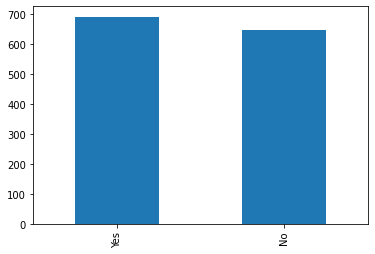

In [33]:
dataset.answer.value_counts().plot(kind='bar')

The next step is to load the `feature-extraction` pipeline from the `transformers` library, which is a pre-trained model that can be used to extract features from the text. We will use the `bert-base-uncased` model, which is the original BERT model.

In [47]:
from transformers import pipeline

feature_extractor = pipeline('feature-extraction', model="distilbert-base-uncased")

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [48]:
# apply the feature extractor to the dataset. Truncation is used to avoid memory issues in cases the example is too long.
features = feature_extractor(list(dataset.text), truncation=True)

In [52]:
# useful check
len(features) == len(dataset)

True

**Question** For each example, what are the dimensions of the extracted features?

In [53]:
# we can average along the token dimension to make every vector have the same dimensions
# but other aggregations could be possible (like just getting the first position).

features_averaged_per_sentence = [np.mean(sentence_embedding, axis=1) for sentence_embedding in features]

In [54]:
# convert to numpy array
features_averaged_per_sentence = np.array(features_averaged_per_sentence).squeeze()

features_averaged_per_sentence.shape

(1337, 768)

As usual, now we can apply scikit-learn to split the data and train a specialized classifier on the extracted features.

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_averaged_per_sentence, dataset.answer, test_size=0.2, random_state=1, stratify=dataset.answer)

In [59]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)

model.fit(X_train, y_train)

from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.96      0.97      0.97       129
         Yes       0.97      0.96      0.97       139

    accuracy                           0.97       268
   macro avg       0.97      0.97      0.97       268
weighted avg       0.97      0.97      0.97       268



**Exercise 1**: What would happen if you use a different pre-trained model, such as:

 * `bert-large-uncased`

 * `distilbert-base-uncased`

**Exercise 2** Compute the classification metrics using a bag-of-words approach (i.e., not based on deep learning).